In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# 1. Load and Preprocess
df = pd.read_csv('Social_Network_Ads.csv')
X = df[['Age', 'EstimatedSalary']].values
y = df['Purchased'].values
y = np.where(y == 0, -1, 1)  # Convert 0/1 to -1/1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [4]:
# 2. QP Formulation
n_samples, n_features = X_train_s.shape
C = 1.0

# Variables
w = cp.Variable(n_features)
b = cp.Variable()
xi = cp.Variable(n_samples)

# Objective: 0.5 * ||w||^2 + C * sum(xi)
objective = cp.Minimize(0.5 * cp.norm(w, 2)**2 + C * cp.sum(xi))

# Constraints: y_i(w.x_i + b) >= 1 - xi  AND  xi >= 0
constraints = [
    cp.multiply(y_train, (X_train_s @ w + b)) >= 1 - xi,
    xi >= 0
]

# Solve
prob = cp.Problem(objective, constraints)
prob.solve()

w_opt = w.value
b_opt = b.value
print(w_opt, b_opt)

[1.6032232 0.971575 ] -0.7688348265267029


In [5]:
# 3. Evaluation
def predict(X, w, b):
    return np.sign(X @ w + b)

y_pred = predict(X_test_s, w_opt, b_opt)
print(f"QP-SVM Accuracy: {accuracy_score(y_test, y_pred):.2f}")

QP-SVM Accuracy: 0.90


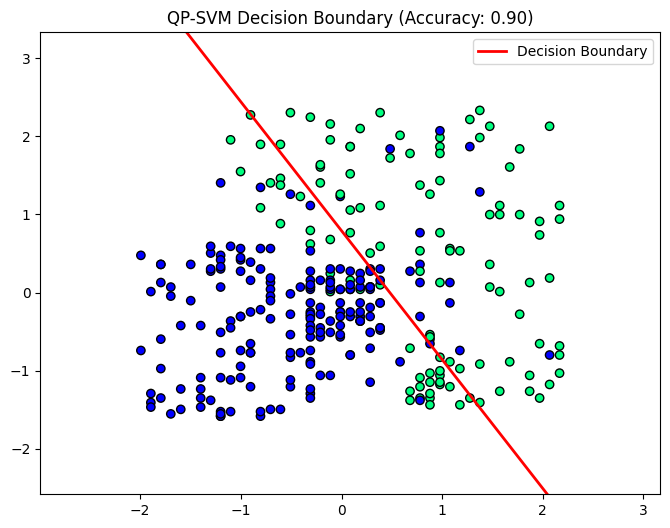

In [6]:
# 4. Visualization
plt.figure(figsize=(8,6))
# Plot data points
plt.scatter(X_train_s[:, 0], X_train_s[:, 1], c=y_train, cmap='winter', edgecolors='k')

# Plot decision boundary (w1*x1 + w2*x2 + b = 0  => x2 = (-w1*x1 - b) / w2)
x1_min, x1_max = X_train_s[:, 0].min() - 1, X_train_s[:, 0].max() + 1
x1_plot = np.linspace(x1_min, x1_max, 100)
x2_plot = (-w_opt[0] * x1_plot - b_opt) / w_opt[1]

plt.plot(x1_plot, x2_plot, 'r-', linewidth=2, label='Decision Boundary')
plt.xlim(x1_min, x1_max)
plt.ylim(X_train_s[:, 1].min() - 1, X_train_s[:, 1].max() + 1)
plt.legend()
plt.title(f"QP-SVM Decision Boundary (Accuracy: {accuracy_score(y_test, y_pred):.2f})")
plt.show()